## Loughran - McDonald Financial Sentiments

In [1]:
# Author: bbaasan
# File: sentiment.ipynb
# Created: 2023-09-05
# Email: bbaasan@gmu.edu
# Purpose: Adding sentiment analysis to the dataframe

In [2]:
import pandas as pd
import numpy as np

In [3]:
lm_df = pd.read_csv('../data/LandMcDonal/LM-SA-2020.csv')

In [4]:
lm_df

,word,sentiment
0,abandon,Negative
1,abandoned,Negative
2,abandoning,Negative
3,abandonment,Negative
4,abandonments,Negative
...,...,...
9747,record low,Negative
9748,record production,Positive
9749,on track,Positive
9750,back foot,Negative


In [14]:
script = pd.read_pickle('../data/aggregate.pkl')[['tagged','transcript', 'clean']]

In [22]:

from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short
import random


# Preprocessing function
def preprocess(document):
    # Convert to lowercase
    #document = document.lower()
    # Remove HTML tags
    document = strip_tags(document)
    # Remove punctuation
    #document = strip_punctuation(document)
    # Remove numbers
    #document = strip_numeric(document)
    # Remove stop words
    document = remove_stopwords(document)
    # Remove words with length less than 3
    document = strip_short(document, minsize=3)
    # Remove extra whitespaces
    document = strip_multiple_whitespaces(document)
    
    return document.split()

# If you have a very large dataframe, you might want to sample it
sample_size = 5000  # Adjust this as per your need
if len(script) > sample_size:
    df_sample = script.sample(n=sample_size)
else:
    df_sample = script

# Apply preprocessing
df_sample['processed'] = df_sample['clean'].apply(preprocess)

# Prepare data for LDA
dictionary = corpora.Dictionary(df_sample['processed'])
corpus = [dictionary.doc2bow(text) for text in df_sample['processed']]

# Train LDA model
NUM_TOPICS = 5  # Adjust the number of topics as per your need
lda_model = models.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')



Topic: 0 
Words: 0.021*"market" + 0.011*"credit" + 0.011*"investment" + 0.011*"financial" + 0.010*"rates" + 0.010*"assets" + 0.009*"management" + 0.008*"increased" + 0.007*"operating" + 0.007*"slide"

Topic: 1 
Words: 0.036*"revenue" + 0.023*"customers" + 0.018*"market" + 0.014*"customer" + 0.012*"product" + 0.011*"services" + 0.010*"technology" + 0.010*"financial" + 0.010*"products" + 0.009*"operating"

Topic: 2 
Words: 0.016*"market" + 0.014*"product" + 0.013*"revenue" + 0.012*"products" + 0.010*"operating" + 0.009*"increased" + 0.009*"customers" + 0.009*"store" + 0.008*"performance" + 0.008*"adjusted"

Topic: 3 
Words: 0.021*"market" + 0.011*"operating" + 0.010*"costs" + 0.009*"customers" + 0.009*"slide" + 0.009*"ebitda" + 0.009*"prices" + 0.009*"performance" + 0.009*"financial" + 0.008*"increased"

Topic: 4 
Words: 0.009*"program" + 0.008*"cancer" + 0.007*"financial" + 0.007*"disease" + 0.006*"product" + 0.006*"studies" + 0.006*"approval" + 0.006*"market" + 0.006*"therapy" + 0.005*

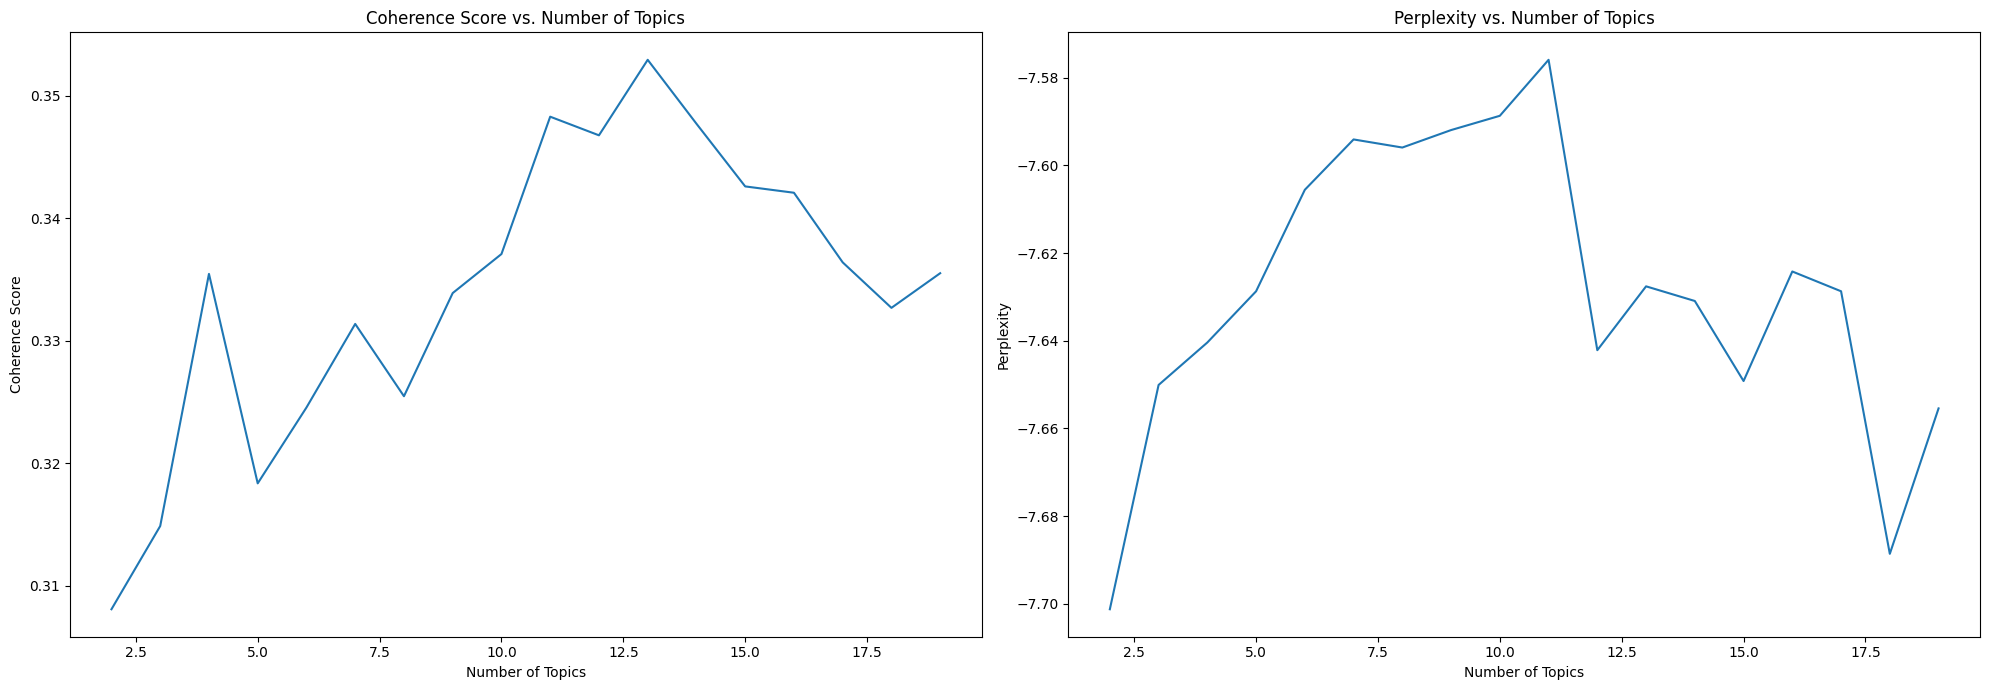

In [24]:
import gensim
from gensim.models import LdaMulticore, CoherenceModel
import matplotlib.pyplot as plt

# Assuming texts is your preprocessed data
#dictionary = gensim.corpora.Dictionary(texts)
#corpus = [dictionary.doc2bow(text) for text in texts]

# Range of number of topics
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Variables to hold results
coherence_values = []
perplexity_values = []

for num_topics in topics_range:
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=100, passes=10, per_word_topics=True)
    coherencemodel = CoherenceModel(model=lda_model, texts=df_sample['processed'], dictionary=dictionary, coherence='c_v')
    
    coherence_values.append(coherencemodel.get_coherence())
    perplexity_values.append(lda_model.log_perplexity(corpus))

# Plotting metrics
plt.figure(figsize=(20,7))

# Coherence
plt.subplot(1, 2, 1)
plt.plot(topics_range, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")

# Perplexity
plt.subplot(1, 2, 2)
plt.plot(topics_range, perplexity_values)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Number of Topics")

plt.tight_layout()
plt.show()


In [25]:
# Assuming lda_model is already trained
num_words = 10
topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)

# Print topics with words
for idx, topic in topics:
    print(f"Topic: {idx} \nWords: {', '.join([word[0] for word in topic])}\n")


Topic: 0 
Words: revenue, customers, operating, performance, program, market, services, programs, backlog, customer

Topic: 1 
Words: revenue, projects, financial, market, project, operating, services, increased, revenues, expenses

Topic: 2 
Words: market, ebitda, revenue, customers, research, operating, performance, financial, increased, industry

Topic: 3 
Words: store, costs, customers, operating, customer, performance, increased, market, financial, opportunity

Topic: 4 
Words: product, cancer, market, program, financial, disease, revenue, studies, therapy, approval

Topic: 5 
Words: market, revenue, financial, management, credit, clients, investment, performance, slide, rates

Topic: 6 
Words: market, customers, revenue, product, operating, technology, industry, customer, products, performance

Topic: 7 
Words: revenue, clients, services, market, adjusted, ebitda, financial, solutions, operating, industry

Topic: 8 
Words: revenue, market, adjusted, product, ebitda, financial, pe

In [27]:
# Print topics with words
#with open('../docs/results/top_topics.txt', mode='w', encoding='utf-8') as tfile:
#    for idx, topic in topics:
#        tfile.write(f"Topic: {idx} \nWords: {', '.join([word[0] for word in topic])}\n\n")


In [26]:
# Assuming lda_model is already trained and corpus is your bag-of-words representation
doc_topics = lda_model.get_document_topics(corpus)

# Example: Print topic distribution for the first document
print(doc_topics[0])


[(2, 0.15182099), (5, 0.6122072), (10, 0.17911546), (18, 0.056360003)]


In [31]:
import pandas as pd

# Assuming you have a DataFrame 'df' and your texts are in a column named 'text'
# Also assuming you've processed your texts and have a dictionary 'id2word' and corpus


# Extract the topic distributions for each document
doc_topics = [lda_model.get_document_topics(bow, minimum_probability=0.0) for bow in corpus]

# Convert the topic distributions into a DataFrame
topics_df = pd.DataFrame([{t[0]: t[1] for t in topics} for topics in doc_topics])

# Rename columns for clarity
topics_df.columns = [f"topic_{col}" for col in topics_df.columns]




In [35]:
df_reseted = df_sample.reset_index(drop=True, inplace=False)

# Concatenate the topics DataFrame with the original DataFrame
result_df = pd.concat([df_reseted, topics_df], axis=1)
result_df

,tagged,transcript,clean,processed,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,Naspers Limited (OTCPK:NPSNY) Full Year 2019 R...,[Naspers Limited (OTCPK:NPSNY) Full Year 2019 ...,naspers limited otcpk npsny dijk illg online f...,"[naspers, limited, otcpk, npsny, dijk, illg, o...",0.674770,0.052497,0.219657,0.044741,0.000063,0.000063,0.000063,0.008019,0.000063,0.000063
1,"Lakeland Industries, Inc. (NASDAQ:LAKE) Q1 202...","[Lakeland Industries, Inc. (NASDAQ:LAKE) Q1 20...",industries fuhrman industries financial partie...,"[industries, fuhrman, industries, financial, p...",0.109920,0.537021,0.000130,0.138868,0.000130,0.102656,0.073568,0.000130,0.027683,0.009893
2,"Byline Bancorp, Inc. (NYSE:BY) Q1 2018 Earning...","[Byline Bancorp, Inc. (NYSE:BY) Q1 2018 Earnin...",byline bancorp financial profiles paracchini c...,"[byline, bancorp, financial, profiles, paracch...",0.019211,0.000145,0.000145,0.000145,0.000145,0.000145,0.031434,0.948339,0.000145,0.000145
3,Wipro Limited (NYSE:WIT) Q3 2015 Earnings Conf...,[Wipro Limited (NYSE:WIT) Q3 2015 Earnings Con...,wipro limited neemuchwala sciences analysts mu...,"[wipro, limited, neemuchwala, sciences, analys...",0.000124,0.146519,0.000124,0.486422,0.000124,0.354526,0.000124,0.008423,0.003490,0.000124
4,AmerisourceBergen (NYSE:ABC) Q1 2013 Earnings ...,[AmerisourceBergen (NYSE:ABC) Q1 2013 Earnings...,amerisourcebergen brungess corporate investor ...,"[amerisourcebergen, brungess, corporate, inves...",0.180407,0.096192,0.000090,0.546281,0.000090,0.009388,0.000090,0.000090,0.000090,0.167284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Harsco Corporation (HSC) Q3 2019 Earnings Conf...,[Harsco Corporation (HSC) Q3 2019 Earnings Con...,harsco corporation investor grasberger financi...,"[harsco, corporation, investor, grasberger, fi...",0.000186,0.904958,0.000186,0.075984,0.000186,0.000186,0.000186,0.000186,0.017753,0.000186
4996,MRC Global Inc. (NYSE:MRC) Q3 2020 Earnings Co...,[MRC Global Inc. (NYSE:MRC) Q3 2020 Earnings C...,investor financial meakim keybanc recorded inv...,"[investor, financial, meakim, keybanc, recorde...",0.000102,0.317134,0.000102,0.210081,0.000102,0.167774,0.014217,0.000102,0.290284,0.000102
4997,"CYS Investments, Inc. (NYSE:CYS) Q4 2017 Earni...","[CYS Investments, Inc. (NYSE:CYS) Q4 2017 Earn...",investments operating decicco financial invest...,"[investments, operating, decicco, financial, i...",0.000198,0.000198,0.527343,0.000198,0.000198,0.000198,0.000198,0.471077,0.000198,0.000197
4998,"Franklin Resources, Inc. (NYSE:BEN) Q1 2022 Ea...","[Franklin Resources, Inc. (NYSE:BEN) Q1 2022 E...",resources investor financial spector distribut...,"[resources, investor, financial, spector, dist...",0.073122,0.000116,0.653292,0.228717,0.000116,0.044175,0.000116,0.000116,0.000116,0.000116


In [36]:
num_topics = 10
num_words_per_topic = 10  # you can adjust this number if you want more or fewer words

for topic_id in range(num_topics):
    terms = lda_model.show_topic(topic_id, num_words_per_topic)
    print(f"Topic {topic_id}:")
    for term, weight in terms:
        print(f"{term} ({weight:.3f})")
    print("\n")


Topic 0:
product (0.016)
store (0.015)
marketing (0.013)
customers (0.013)
customer (0.011)
consumer (0.011)
market (0.011)
revenue (0.010)
products (0.010)
online (0.009)


Topic 1:
market (0.027)
products (0.014)
operating (0.014)
product (0.013)
performance (0.012)
adjusted (0.011)
customers (0.010)
increased (0.010)
margins (0.010)
slide (0.009)


Topic 2:
market (0.025)
investment (0.023)
assets (0.020)
management (0.013)
financial (0.011)
investments (0.011)
credit (0.011)
slide (0.009)
performance (0.008)
opportunities (0.008)


Topic 3:
revenue (0.045)
services (0.015)
adjusted (0.014)
financial (0.013)
operating (0.013)
revenues (0.012)
clients (0.012)
market (0.011)
ebitda (0.010)
increased (0.009)


Topic 4:
drilling (0.020)
costs (0.013)
slide (0.012)
exploration (0.011)
prices (0.011)
project (0.010)
barrels (0.009)
financial (0.009)
program (0.009)
operations (0.009)


Topic 5:
customers (0.037)
revenue (0.030)
market (0.023)
customer (0.020)
product (0.017)
technology (0